In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asteroid-impacts/orbits - orbits.csv


#### Dataset modified to separate Hazardous and Classification columns for implementation of multiple classification algorithms

## IMPORT LIBRARIES

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report,precision_score, recall_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

In [27]:
import warnings
warnings.filterwarnings('ignore')

## DATA UNDERSTANDING

In [8]:
orbits_df = pd.read_csv('/kaggle/input/asteroid-impacts/orbits - orbits.csv')
orbits_df.head()

Object Name  Epoch (TDB)  Orbit Axis (AU)  Orbit Eccentricity  \
0      433 Eros        57800           1.4579              0.2226   
1    719 Albert        57800           2.6385              0.5479   
2    887 Alinda        57800           2.4787              0.5671   
3  1036 Ganymed        57800           2.6628              0.5338   
4     1221 Amor        57800           1.9191              0.4356   

   Orbit Inclination (deg)  Perihelion Argument (deg)  Node Longitude (deg)  \
0                  10.8277                   178.8050              304.3265   
1                  11.5822                   156.1409              183.9204   
2                   9.3561                   350.3482              110.5444   
3                  26.6929                   132.4690              215.5551   
4                  11.8795                    26.6572              171.3448   

   Mean Anomoly (deg)  Perihelion Distance (AU)  Aphelion Distance (AU)  \
0            319.3111                    1.1335                    1.78   
1            224.5535                    1.1928                    4.08   
2            351.3730                    1.0731                    3.88   
3             92.5640                    1.2413                    4.08   
4            313.7379                    1.0832                    2.76   

   Orbital Period (yr)  Minimum Orbit Intersection Distance (AU)  \
0                 1.76                                    0.1492   
1                 4.29                                    0.2004   
2                 3.90                                    0.0925   
3                 4.35                                    0.3421   
4                 2.66                                    0.1068   

   Orbital Reference  Asteroid Magnitude Classification  Hazardous  
0                598               11.16  Amor Asteroid      False  
1                 78               15.50  Amor Asteroid      False  
2                188               13.40  Amor Asteroid      False  
3                597                9.45  Amor Asteroid      False  
4                 70               17.70  Amor Asteroid      False

In [9]:
orbits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15635 entries, 0 to 15634
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Object Name                               15635 non-null  object 
 1   Epoch (TDB)                               15635 non-null  int64  
 2   Orbit Axis (AU)                           15635 non-null  float64
 3   Orbit Eccentricity                        15635 non-null  float64
 4   Orbit Inclination (deg)                   15635 non-null  float64
 5   Perihelion Argument (deg)                 15635 non-null  float64
 6   Node Longitude (deg)                      15635 non-null  float64
 7   Mean Anomoly (deg)                        15635 non-null  float64
 8   Perihelion Distance (AU)                  15635 non-null  float64
 9   Aphelion Distance (AU)                    15635 non-null  float64
 10  Orbital Period (yr)               

In [10]:
orbits_df.describe()

Epoch (TDB)  Orbit Axis (AU)  Orbit Eccentricity  \
count  15635.000000     15635.000000        15635.000000   
mean   57365.394947         1.781002            0.449694   
std     1167.238040         0.603229            0.176000   
min    44221.000000         0.547600            0.004400   
25%    57800.000000         1.323600            0.322700   
50%    57800.000000         1.735500            0.462900   
75%    57800.000000         2.208650            0.572900   
max    57800.000000        21.395400            0.969500   

       Orbit Inclination (deg)  Perihelion Argument (deg)  \
count             15635.000000                15635.00000   
mean                 12.941175                  181.50956   
std                  11.303231                  103.86248   
min                   0.014700                    0.00810   
25%                   4.762450                   92.43535   
50%                   9.197400                  183.31780   
75%                  18.510900                  270.91745   
max                 154.375100                  359.99420   

       Node Longitude (deg)  Mean Anomoly (deg)  Perihelion Distance (AU)  \
count          15635.000000        15635.000000              15635.000000   
mean             172.672154          172.834863                  0.914912   
std              103.384143          116.123065                  0.240309   
min                0.007000            0.003100                  0.070700   
25%               82.241950           62.040250                  0.776750   
50%              172.173400          167.750200                  0.965800   
75%              253.660050          281.443100                  1.080300   
max              359.998100          359.998200                  1.300000   

       Aphelion Distance (AU)  Orbital Period (yr)  \
count            15635.000000         15635.000000   
mean                 2.647087             2.473406   
std                  1.142659             1.517588   
min                  0.800000             0.410000   
25%                  1.740000             1.520000   
50%                  2.520000             2.290000   
75%                  3.420000             3.280000   
max                 41.540000            98.970000   

       Minimum Orbit Intersection Distance (AU)  Orbital Reference  \
count                              15635.000000       15635.000000   
mean                                   0.101884          21.885257   
std                                    0.105937          33.632091   
min                                    0.000000           1.000000   
25%                                    0.018700           6.000000   
50%                                    0.062000          11.000000   
75%                                    0.159150          23.000000   
max                                    0.706900         635.000000   

       Asteroid Magnitude  
count        15634.000000  
mean            22.286336  
std              3.016002  
min              9.450000  
25%             19.900000  
50%             22.200000  
75%             24.600000  
max             33.200000

In [11]:
orbits_df.columns

Index(['Object Name', 'Epoch (TDB)', 'Orbit Axis (AU)', 'Orbit Eccentricity',
       'Orbit Inclination (deg)', 'Perihelion Argument (deg)',
       'Node Longitude (deg)', 'Mean Anomoly (deg)',
       'Perihelion Distance (AU)', 'Aphelion Distance (AU)',
       'Orbital Period (yr)', 'Minimum Orbit Intersection Distance (AU)',
       'Orbital Reference', 'Asteroid Magnitude', 'Classification',
       'Hazardous'],
      dtype='object')

In [12]:
orbits_df['Classification'].dropna().unique().tolist()

['Amor Asteroid', 'Apollo Asteroid', 'Aten Asteroid', 'Apohele Asteroid']

In [13]:
orbits_df['Hazardous'].dropna().unique().tolist()

[False, True]

In [14]:
# orbits_df['Object Name'].dropna().unique().tolist()
# orbits_df['']

## DATA PREPROCESSING

In [15]:
df = orbits_df.copy()

In [16]:
df['Asteroid Magnitude'] = df['Asteroid Magnitude'].fillna(0)

In [17]:
df['Asteroid Magnitude'].isnull().sum()

0

In [18]:
df.isnull().sum()

Object Name                                 0
Epoch (TDB)                                 0
Orbit Axis (AU)                             0
Orbit Eccentricity                          0
Orbit Inclination (deg)                     0
Perihelion Argument (deg)                   0
Node Longitude (deg)                        0
Mean Anomoly (deg)                          0
Perihelion Distance (AU)                    0
Aphelion Distance (AU)                      0
Orbital Period (yr)                         0
Minimum Orbit Intersection Distance (AU)    0
Orbital Reference                           0
Asteroid Magnitude                          0
Classification                              0
Hazardous                                   0
dtype: int64

## EXPLORATORY DATA ANALYSIS

In [19]:
df

Object Name  Epoch (TDB)  Orbit Axis (AU)  Orbit Eccentricity  \
0          433 Eros        57800           1.4579              0.2226   
1        719 Albert        57800           2.6385              0.5479   
2        887 Alinda        57800           2.4787              0.5671   
3      1036 Ganymed        57800           2.6628              0.5338   
4         1221 Amor        57800           1.9191              0.4356   
...             ...          ...              ...                 ...   
15630    (2017 CX1)        57800           1.4096              0.2946   
15631    (2017 CO5)        57789           2.2612              0.4429   
15632    (2017 CP5)        57800           1.5131              0.3275   
15633    (2017 CR5)        57793           1.8815              0.4646   
15634    (6344 P-L)        57800           2.8043              0.6672   

       Orbit Inclination (deg)  Perihelion Argument (deg)  \
0                      10.8277                   178.8050   
1                      11.5822                   156.1409   
2                       9.3561                   350.3482   
3                      26.6929                   132.4690   
4                      11.8795                    26.6572   
...                        ...                        ...   
15630                   3.4011                   353.7433   
15631                  28.9728                   147.6444   
15632                  14.2656                    46.6749   
15633                   7.1647                     0.2261   
15634                   4.7249                   234.1260   

       Node Longitude (deg)  Mean Anomoly (deg)  Perihelion Distance (AU)  \
0                  304.3265            319.3111                    1.1335   
1                  183.9204            224.5535                    1.1928   
2                  110.5444            351.3730                    1.0731   
3                  215.5551             92.5640                    1.2413   
4                  171.3448            313.7379                    1.0832   
...                     ...                 ...                       ...   
15630              138.1226              8.7456                    0.9943   
15631              348.1501              5.7171                    1.2598   
15632              130.7234            344.8663                    1.0175   
15633              136.7746              1.1654                    1.0073   
15634              183.5747            349.5302                    0.9332   

       Aphelion Distance (AU)  Orbital Period (yr)  \
0                        1.78                 1.76   
1                        4.08                 4.29   
2                        3.88                 3.90   
3                        4.08                 4.35   
4                        2.76                 2.66   
...                       ...                  ...   
15630                    1.82                 1.67   
15631                    3.26                 3.40   
15632                    2.01                 1.86   
15633                    2.76                 2.58   
15634                    4.68                 4.70   

       Minimum Orbit Intersection Distance (AU)  Orbital Reference  \
0                                        0.1492                598   
1                                        0.2004                 78   
2                                        0.0925                188   
3                                        0.3421                597   
4                                        0.1068                 70   
...                                         ...                ...   
15630                                    0.0092                  2   
15631                                    0.3136                  2   
15632                                    0.0934                  1   
15633                                    0.0213                  1   
15634                                    0.0288       

<Axes: title={'center': 'Hazardous Count'}, xlabel='Hazardous', ylabel='count'>

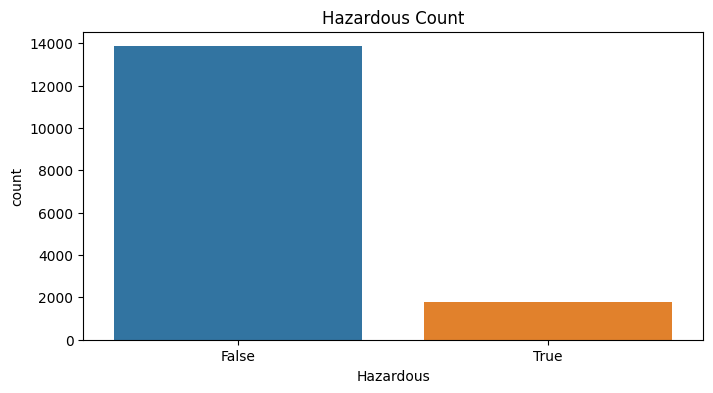

In [20]:
plt.figure(figsize=(8,4))
plt.title('Hazardous Count')
sns.countplot(data=df, x ='Hazardous')

In [ ]:
df = df.drop('Object Name', axis=1)

<Axes: >

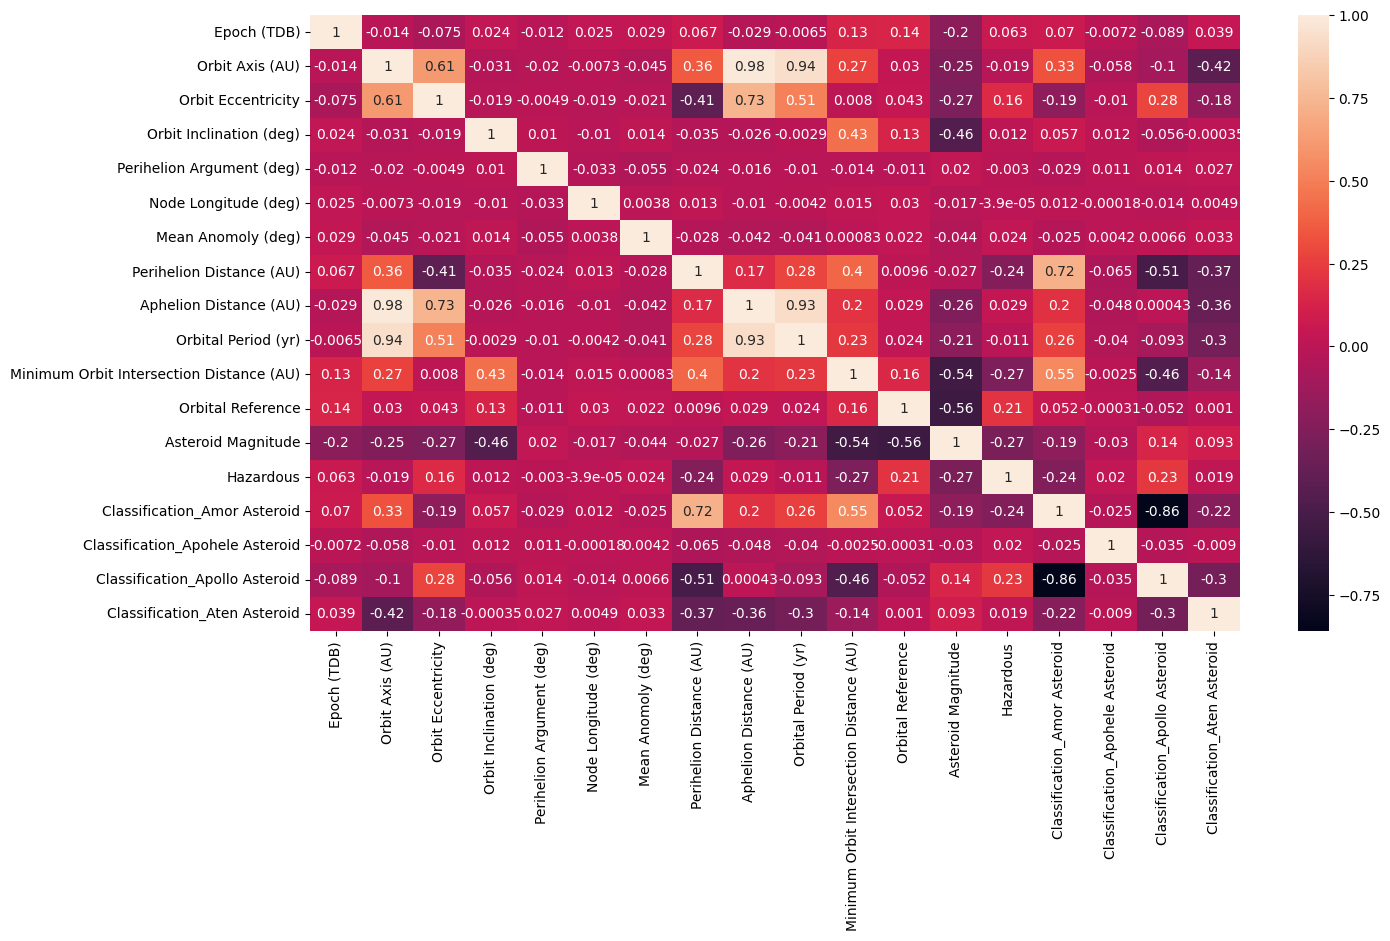

In [25]:
plt.figure(figsize=(15,8))
sns.heatmap(data=pd.get_dummies(df).corr(), annot=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

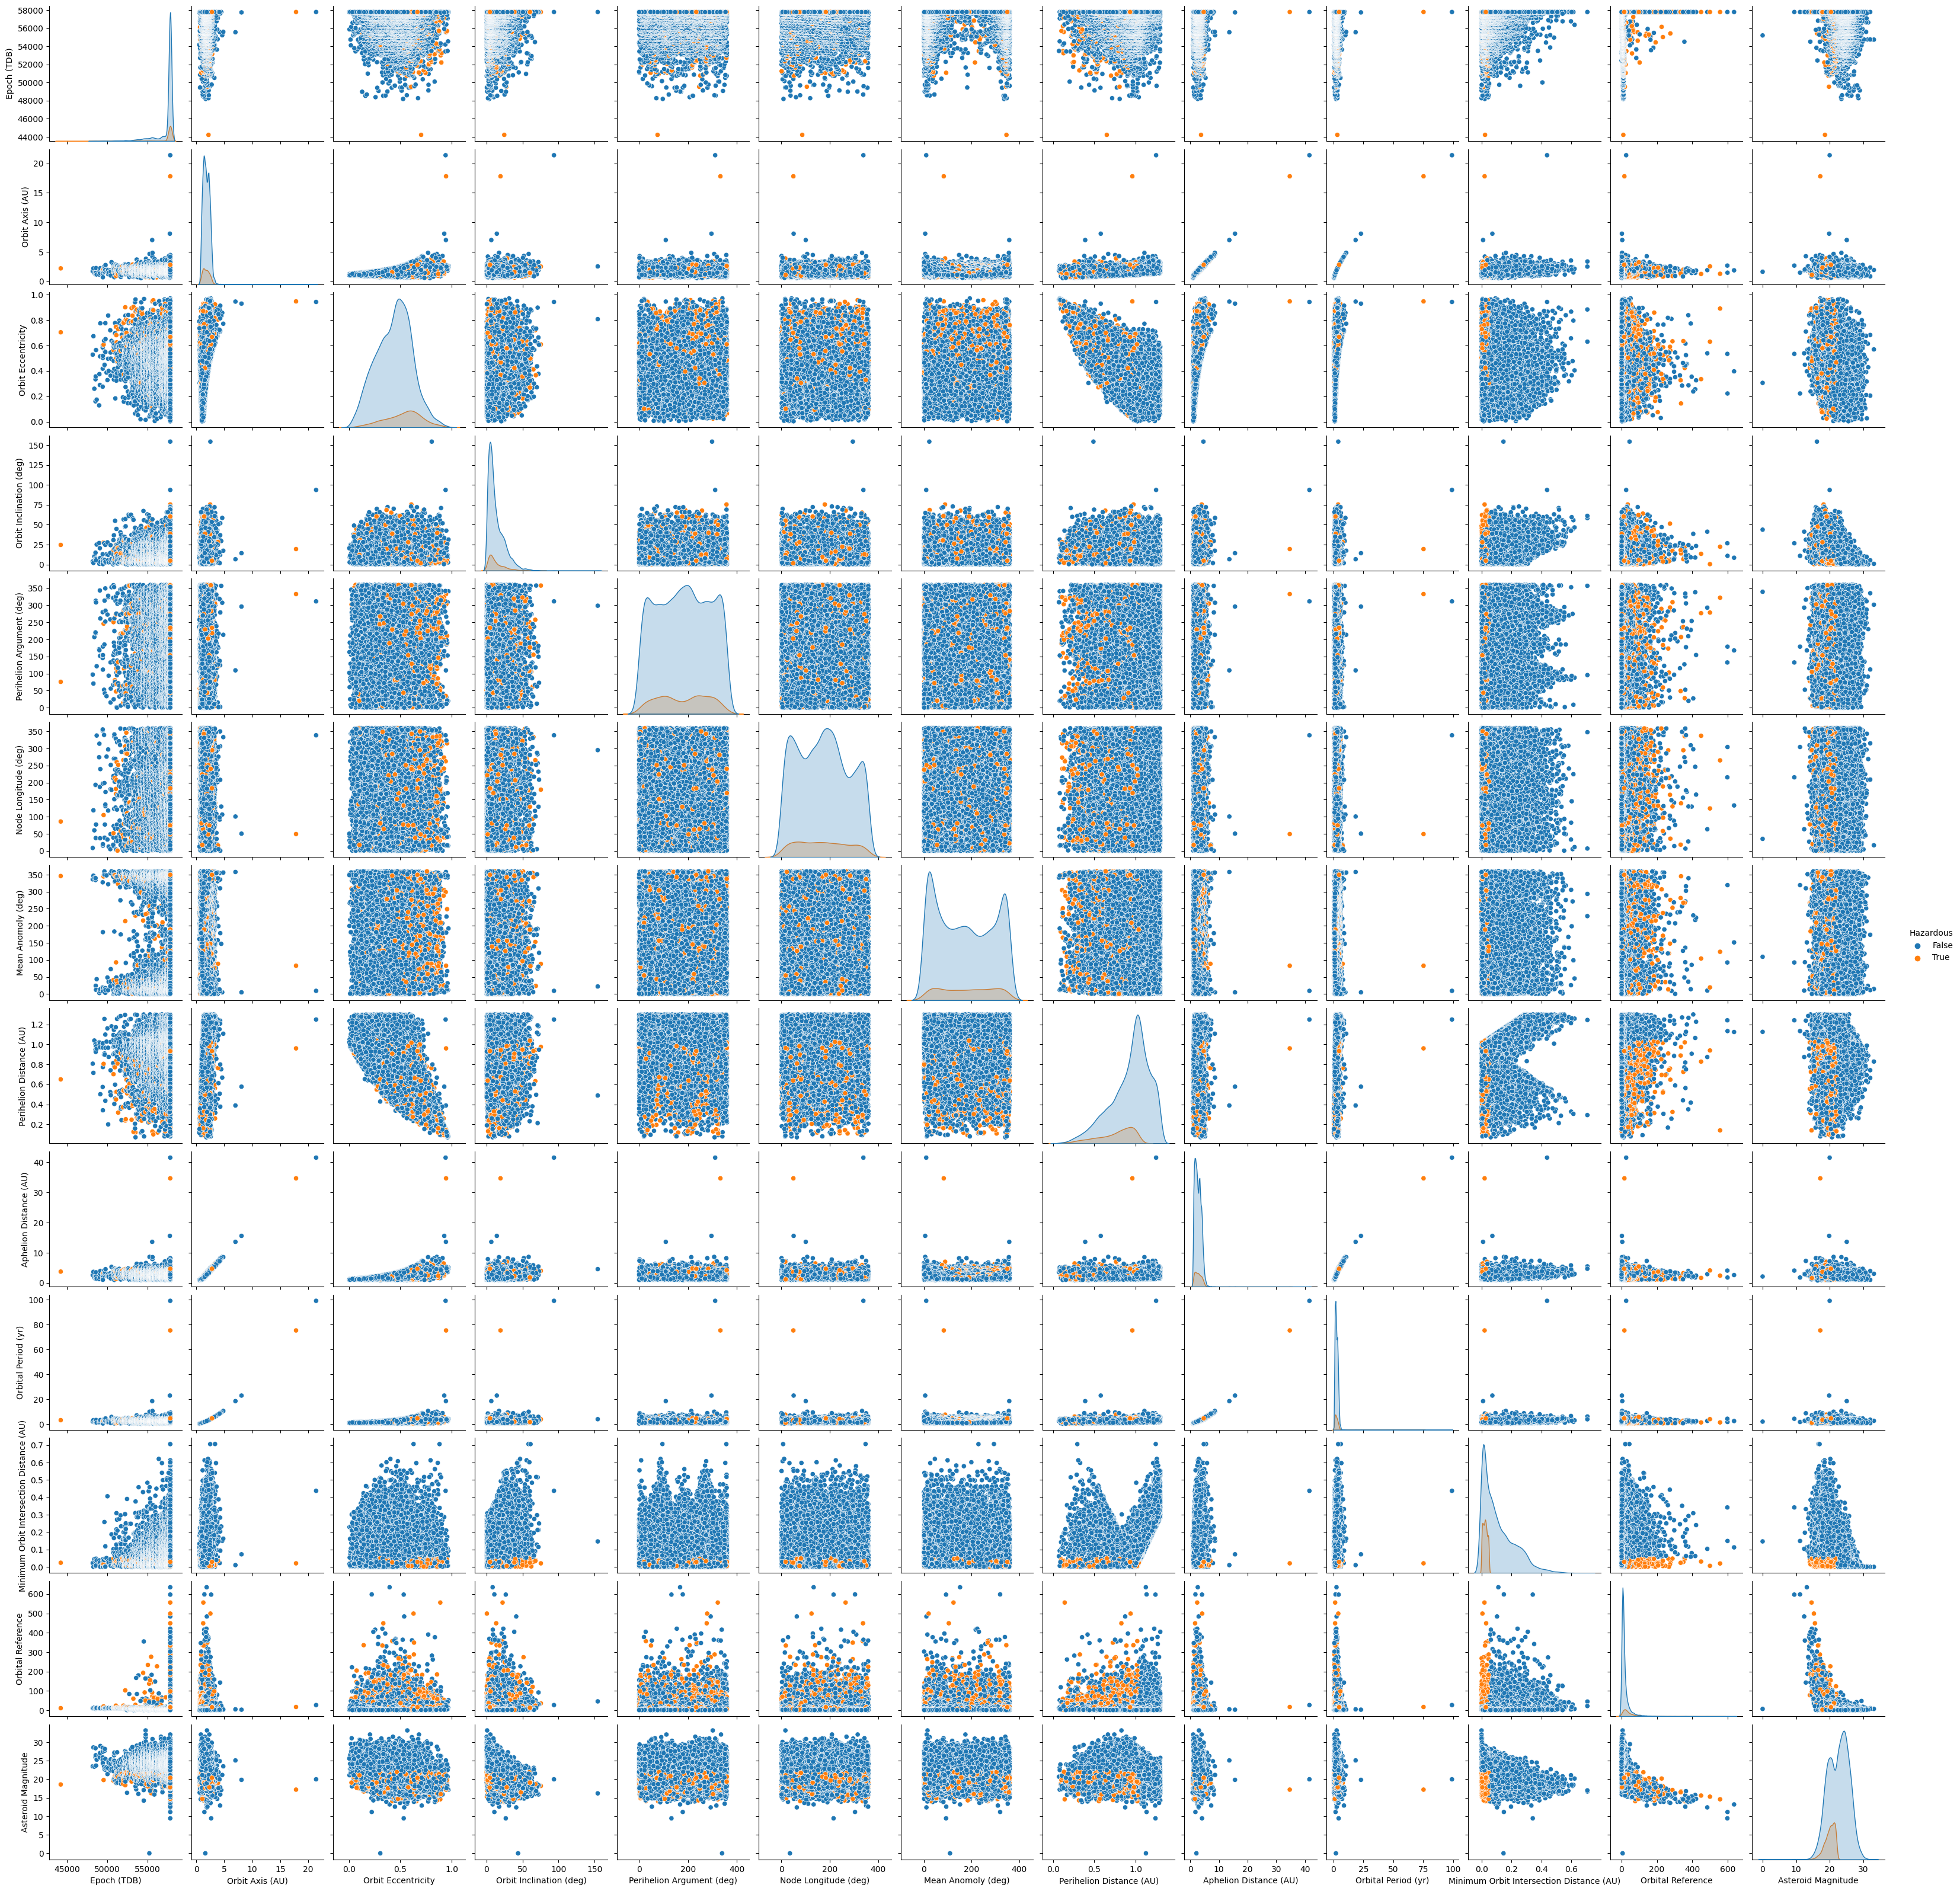

In [26]:
sns.pairplot(data=df, hue='Hazardous')

In [30]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.corr()['Hazardous'].sort_values()

Asteroid Magnitude                         -0.273144
Minimum Orbit Intersection Distance (AU)   -0.265237
Perihelion Distance (AU)                   -0.235056
Orbit Axis (AU)                            -0.019120
Orbital Period (yr)                        -0.010671
Perihelion Argument (deg)                  -0.002966
Node Longitude (deg)                       -0.000039
Orbit Inclination (deg)                     0.012278
Classification_Aten Asteroid                0.019398
Classification_Apohele Asteroid             0.020029
Mean Anomoly (deg)                          0.023713
Aphelion Distance (AU)                      0.029260
Epoch (TDB)                                 0.062560
Orbit Eccentricity                          0.160092
Orbital Reference                           0.205615
Classification_Apollo Asteroid              0.225298
Hazardous                                   1.000000
Name: Hazardous, dtype: float64

<Axes: title={'center': 'Classification Count colored by Hazardous'}, xlabel='Classification', ylabel='count'>

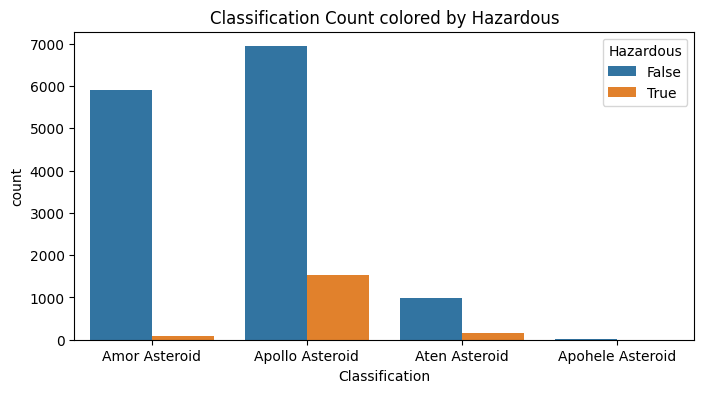

In [32]:
plt.figure(figsize=(8,4))
plt.title('Classification Count colored by Hazardous')
sns.countplot(data=df, x='Classification', hue='Hazardous')

## Model Building

In [33]:
X = df[['Classification','Hazardous']]
X = pd.get_dummies(X, columns=['Classification','Hazardous'], drop_first=True)
y = df['Asteroid Magnitude']

In [34]:
X

Classification_Apohele Asteroid  Classification_Apollo Asteroid  \
0                                False                           False   
1                                False                           False   
2                                False                           False   
3                                False                           False   
4                                False                           False   
...                                ...                             ...   
15630                            False                            True   
15631                            False                           False   
15632                            False                           False   
15633                            False                            True   
15634                            False                            True   

       Classification_Aten Asteroid  Hazardous_True  
0                             False           False  
1                             False           False  
2                             False           False  
3                             False           False  
4                             False           False  
...                             ...             ...  
15630                         False           False  
15631                         False           False  
15632                         False           False  
15633                         False           False  
15634                         False            True  

[15635 rows x 4 columns]

In [35]:
y

0        11.16
1        15.50
2        13.40
3         9.45
4        17.70
         ...  
15630    28.21
15631    20.04
15632    24.74
15633    26.95
15634    20.40
Name: Asteroid Magnitude, Length: 15635, dtype: float64

#### Random Forest Regressor Model

In [36]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

<Axes: >

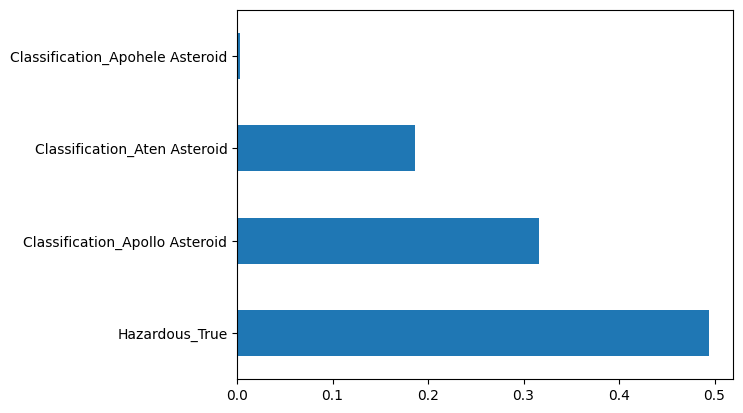

In [37]:
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind='barh')

In [38]:
top_features = importance[importance > 0.1].index  # keep features with >1% importance
X_reduced = X[top_features]

In [39]:
top_features

Index(['Classification_Apollo Asteroid', 'Classification_Aten Asteroid',
       'Hazardous_True'],
      dtype='object')

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
y_test

13101    20.7
8825     23.2
9345     20.7
8396     23.2
3942     21.4
         ... 
5899     27.2
5318     21.4
6685     24.4
9481     20.6
15376    23.0
Name: Asteroid Magnitude, Length: 3127, dtype: float64

In [42]:
y_pred = rf.predict(X_test)
y_pred

array([21.57627075, 21.57627075, 23.28365386, ..., 23.28365386,
       21.57627075, 23.28365386])

In [43]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 2.81


mean_squared_error: compares predictions with actual values

squared=False: gives RMSE (root mean squared error), a commonly used regression metric

Lower RMSE = better model (closer predictions to actual sales)

#### XGBoost Regressor Model

In [44]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [45]:
xgb_rmse = mean_squared_error(y_test, xgb.predict(X_test), squared=False)

In [46]:
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

XGBoost RMSE: 2.81


Step:

1. Simulate data- Creates a realistic pricing dataset
2. Grid Search- Tunes RandomForest for best hyperparameters
3. Heatmap- Visual view of which params work best
4. XGBoost model- Compares a gradient boosting model with RF
5. RMSE- Tells how accurate each model is at predicting demand


### Hyperparamter Tuning

#### for Random Forest

In [47]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

In [48]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, squared=False),
    cv=3,
    return_train_score=True,
    n_jobs=-1
)

In [49]:
# Fit grid search
grid_search.fit(X, y)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated RMSE:", grid_search.best_score_)

Best Parameters: {'max_depth': 3, 'min_samples_split': 2}
Best Cross-Validated RMSE: 3.036259017173151


#### for XG-Boosting

In [50]:
param_grid1 = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3]
}

In [51]:
grid_search1 = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid1,
    scoring=make_scorer(mean_squared_error, squared=False),
    cv=3,
    return_train_score=True,
    n_jobs=-1
)

In [52]:
# Fit grid search
grid_search1.fit(X, y)

# Best parameters and score
print("Best Parameters:", grid_search1.best_params_)
print("Best Cross-Validated RMSE:", grid_search1.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Best Cross-Validated RMSE: 3.0969643443415555


## Baseline Model Exploration

In [57]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    
    model_scores = {}
    model_recall = {}
    model_f1 = {}
    model_precision = {}
    
    for name, model in models.items():
        model.fit(X_train,y_train)
        y_preds = model.predict(X_test)
        print(name)
        print(classification_report(y_test, y_preds))
        print('\n')
        print('_________________________________________________________')
        model_scores[name] = model.score(X_test,y_test)
        model_recall[name] = recall_score(y_test, y_preds)
        model_f1[name] = f1_score(y_test, y_preds)
        model_precision[name] = precision_score(y_test, y_preds)

    model_scores = pd.DataFrame(model_scores, index=['Score']).transpose()
    model_scores = model_scores.sort_values('Score')
    model_recall = pd.DataFrame(model_recall, index=['Recall']).transpose()
    model_recall = model_recall.sort_values('Recall')
    model_f1 = pd.DataFrame(model_f1, index=['F1']).transpose()
    model_f1 = model_f1.sort_values('F1')
    model_precision = pd.DataFrame(model_precision, index=['Precision']).transpose()
    model_precision = model_precision.sort_values('Precision')
        
    return model_scores, model_recall, model_f1, model_precision

In [58]:
models = {'LogisticRegression': LogisticRegression(max_iter=10000),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'SVC': SVC(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': XGBClassifier(objective='binary:logistic',eval_metric=['logloss']),
          'XGBRFClassifier': XGBRFClassifier(objective='binary:logistic',eval_metric=['logloss'])
         }

In [65]:
X = df.drop('Hazardous', axis=1)
y = df['Hazardous']
X = pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y, drop_first=True)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
model_scores, model_recall, model_f1, model_precision = fit_and_score(models, X_train, X_test, y_train, y_test)

LogisticRegression
              precision    recall  f1-score   support

       False       0.97      0.98      0.98      2783
        True       0.84      0.78      0.81       344

    accuracy                           0.96      3127
   macro avg       0.91      0.88      0.89      3127
weighted avg       0.96      0.96      0.96      3127



_________________________________________________________
KNeighborsClassifier
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      2783
        True       0.72      0.60      0.66       344

    accuracy                           0.93      3127
   macro avg       0.84      0.79      0.81      3127
weighted avg       0.93      0.93      0.93      3127



_________________________________________________________
SVC
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      2783
        True       0.91      0.82      0.86       344

    accuracy      

### Cross Validation

In [70]:
def get_baseline_cv_scores(model, X, y, cv=5):
    
    model_scores = {}
    model_recall = {}
    model_f1 = {}
    model_precision = {}
    
    for name, model in models.items():
        
        print(name)
        cv_accuracy = cross_val_score(model,X,y,cv=cv,
                             scoring='accuracy')
        print(f'Cross Validaion accuracy Scores: {cv_accuracy}')
        print(f'Cross Validation accuracy Mean Score: {cv_accuracy.mean()}')

        cv_precision = cross_val_score(model,X,y,cv=cv,
                             scoring='precision')
        print(f'Cross Validaion precision Scores: {cv_precision}')
        print(f'Cross Validation precision Mean Score: {cv_precision.mean()}')

        cv_recall = cross_val_score(model,X,y,cv=cv,
                             scoring='recall')
        print(f'Cross Validaion recall Scores: {cv_recall}')
        print(f'Cross Validation recall Mean Score: {cv_recall.mean()}')

        cv_f1 = cross_val_score(model,X,y,cv=cv,
                             scoring='f1')
        print(f'Cross Validaion f1 Scores: {cv_f1}')
        print(f'Cross Validation f1 Mean Score: {cv_f1.mean()}') 
        print('\n')
        print('________________________________________________________________')

        model_scores[name] = cv_accuracy.mean()
        model_recall[name] = cv_precision.mean()
        model_f1[name] = cv_recall.mean()
        model_precision[name] = cv_f1.mean()
    
    return model_scores, model_recall, model_f1, model_precision


In [71]:
models = {'LogisticRegression': LogisticRegression(max_iter=10000),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'SVC': SVC(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': XGBClassifier(objective='binary:logistic',eval_metric=['logloss']),
          'XGBRFClassifier': XGBRFClassifier(objective='binary:logistic',eval_metric=['logloss'])}

In [72]:
model_scores, model_recall, model_f1, model_precision = get_baseline_cv_scores(models, X_train, y_train, cv=5)

LogisticRegression
Cross Validaion accuracy Scores: [0.95203837 0.95643485 0.95923261 0.95681727 0.95481807]
Cross Validation accuracy Mean Score: 0.9558682362386779
Cross Validaion precision Scores: [0.81992337 0.82246377 0.87449393 0.84291188 0.82222222]
Cross Validation precision Mean Score: 0.8364030333011632
Cross Validaion recall Scores: [0.7456446  0.79094077 0.75261324 0.76655052 0.77351916]
Cross Validation recall Mean Score: 0.7658536585365854
Cross Validaion f1 Scores: [0.7810219  0.80639432 0.80898876 0.80291971 0.79712747]
Cross Validation f1 Mean Score: 0.7992904309258916


________________________________________________________________
KNeighborsClassifier
Cross Validaion accuracy Scores: [0.93245404 0.93045564 0.92166267 0.92682927 0.93402639]
Cross Validation accuracy Mean Score: 0.9290855999726408
Cross Validaion precision Scores: [0.75877193 0.74889868 0.70967742 0.75242718 0.7699115 ]
Cross Validation precision Mean Score: 0.747937343296859
Cross Validaion recall S

In [73]:
model_f1 = pd.DataFrame(model_f1, index=['F1'])
model_f1.transpose().sort_values('F1')

F1
KNeighborsClassifier        0.575610
LogisticRegression          0.765854
SVC                         0.775610
XGBClassifier               0.997213
GradientBoostingClassifier  0.998606
RandomForestClassifier      0.999303
AdaBoostClassifier          0.999303
XGBRFClassifier             0.999303
DecisionTreeClassifier      1.000000

We will go with the **RandomForestClassifier** to bulid our model.

## Model Evaluation

In [74]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

#### Classification Report

In [77]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2783
        True       1.00      1.00      1.00       344

    accuracy                           1.00      3127
   macro avg       1.00      1.00      1.00      3127
weighted avg       1.00      1.00      1.00      3127



#### Confusion Matrix

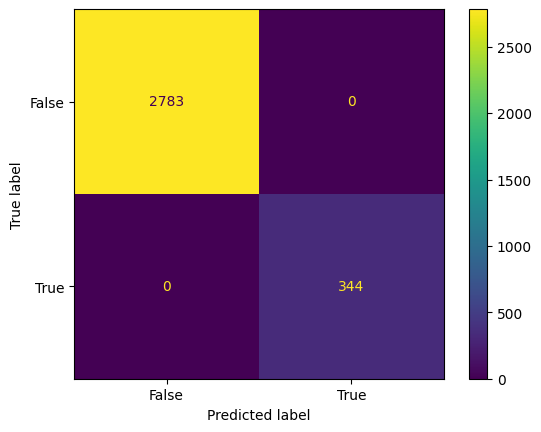

In [80]:
ConfusionMatrixDisplay.from_estimator(model, X_test,y_test)

#### ROC Curve

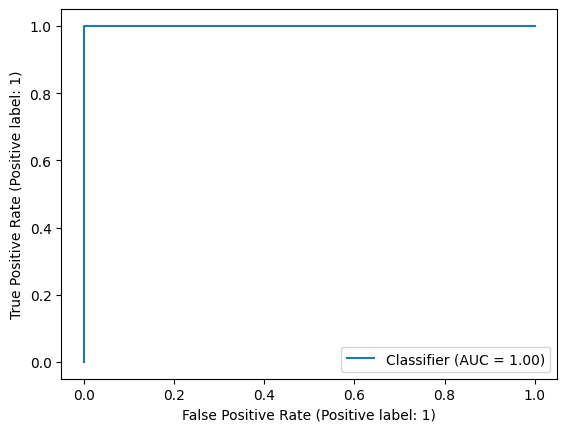

In [79]:
RocCurveDisplay.from_predictions(y_test, y_preds)

In [81]:
def get_cv_score(model, X, y, cv=5):
    
    
    cv_accuracy = cross_val_score(model,X,y,cv=cv,
                         scoring='accuracy')
    print(f'Cross Validaion accuracy Scores: {cv_accuracy}')
    print(f'Cross Validation accuracy Mean Score: {cv_accuracy.mean()}')
    
    cv_precision = cross_val_score(model,X,y,cv=cv,
                         scoring='precision')
    print(f'Cross Validaion precision Scores: {cv_precision}')
    print(f'Cross Validation precision Mean Score: {cv_precision.mean()}')
    
    cv_recall = cross_val_score(model,X,y,cv=cv,
                         scoring='recall')
    print(f'Cross Validaion recall Scores: {cv_recall}')
    print(f'Cross Validation recall Mean Score: {cv_recall.mean()}')
    
    cv_f1 = cross_val_score(model,X,y,cv=cv,
                         scoring='f1')
    print(f'Cross Validaion f1 Scores: {cv_f1}')
    print(f'Cross Validation f1 Mean Score: {cv_f1.mean()}')   
    
    cv_merics = pd.DataFrame({'Accuracy': cv_accuracy.mean(),
                         'Precision': cv_precision.mean(),
                         'Recall': cv_recall.mean(),
                         'f1': cv_recall.mean()},index=[0])

    return cv_merics

In [83]:
cv_merics = get_cv_score(model, X_train, y_train, cv=5)
cv_merics

Cross Validaion accuracy Scores: [1.         0.99960032 0.99960032 1.         0.99960016]
Cross Validation accuracy Mean Score: 0.9997601598848869
Cross Validaion precision Scores: [1.         1.         1.         1.         0.99652778]
Cross Validation precision Mean Score: 0.9993055555555556
Cross Validaion recall Scores: [1.         0.99651568 1.         1.         1.        ]
Cross Validation recall Mean Score: 0.9993031358885018
Cross Validaion f1 Scores: [1.         0.9982548  0.9982548  1.         0.99826087]
Cross Validation f1 Mean Score: 0.9989540936338115


Accuracy  Precision    Recall        f1
0   0.99976   0.999306  0.999303  0.999303

## Feature Importance

In [85]:
imp_features = model.feature_importances_
imp_features = pd.DataFrame(model.feature_importances_, index=X.columns.values)

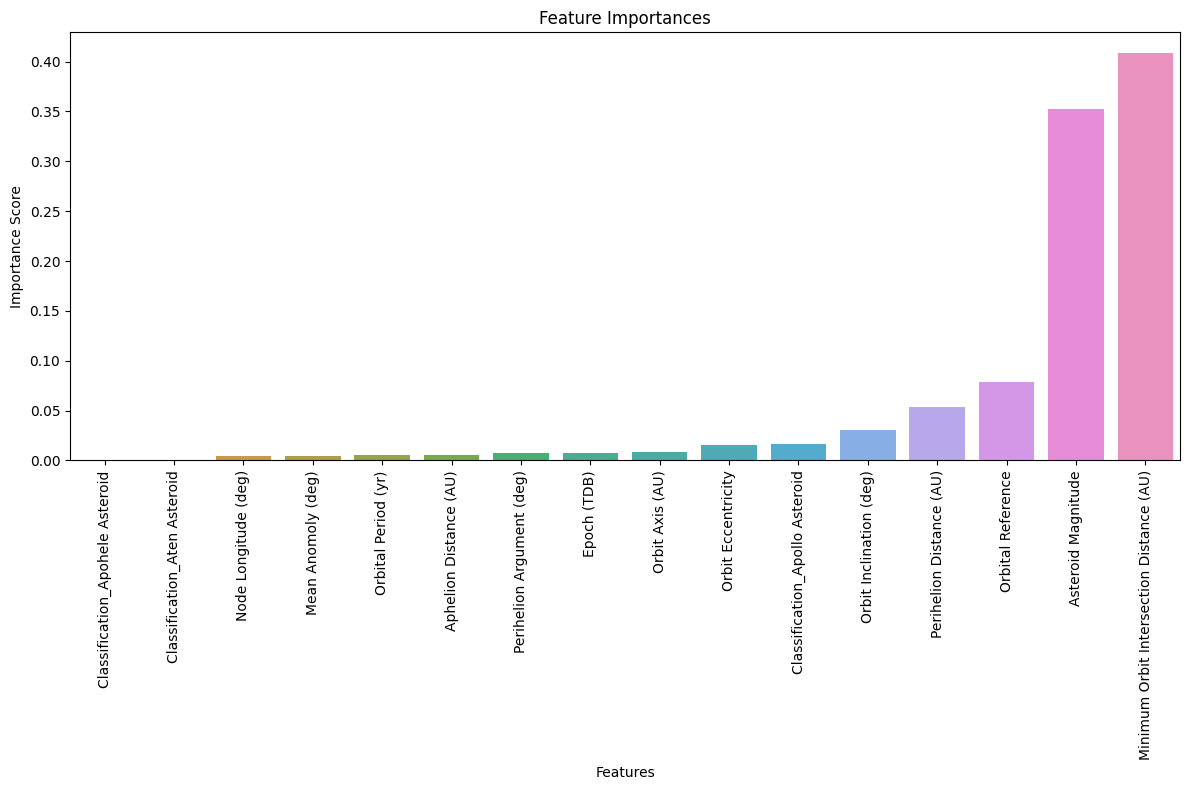

In [89]:
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.xticks(rotation=90)
sns.barplot(data=imp_features.sort_values(0).T)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()